In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchcps.kernel.rkhs import GaussianKernel
from torchcps.kernel.nn import (
    KernelConv,
    KernelMap,
    KernelGraphFilter,
    KernelPool,
    KernelNorm,
    Mixture,
)

In [3]:
# create a datset of 2D signals with noise
n_samples = 10_000
n_sensors = 4
n_measurements = 10
n_dimensions = 2
width = 1000

noise_range = 10
noise_bearing = 0.1

with torch.no_grad():
    targets = width / 2 * torch.rand(n_samples, n_dimensions) - width / 4
    sensors = width / 2 * torch.rand(n_samples, n_sensors, n_dimensions) / 2

    # relative position of targets to sensors
    dx = targets[:, None] - sensors
    dx = dx[..., None, :]
    # add noise in polar coordinates
    measurements_range = (
        torch.norm(dx, dim=-1)
        + torch.randn(n_samples, n_sensors, n_measurements) * noise_range
    )
    measurements_bearing = (
        torch.atan2(dx[..., 1], dx[..., 0])
        + torch.randn(n_samples, n_sensors, n_measurements) * noise_bearing
    )
    # convert back to cartesian coordinates
    measurements = sensors[..., None, :] + torch.stack(
        [
            measurements_range * torch.cos(measurements_bearing),
            measurements_range * torch.sin(measurements_bearing),
        ],
        dim=-1,
    )
    # combine the n_sensors and n_measurements dimensions
    measurements = measurements.reshape(
        n_samples, n_sensors * n_measurements, n_dimensions
    )
    targets = targets[:, None, None, :]
    measurements = measurements[:, None, :, :]

In [4]:
# evaluate naive strategy of taking mean of measurements
input_mean = measurements.mean(2, True)
(input_mean - targets).abs().mean()

tensor(2.5844)

### Visualize the distribution of measurements and targets

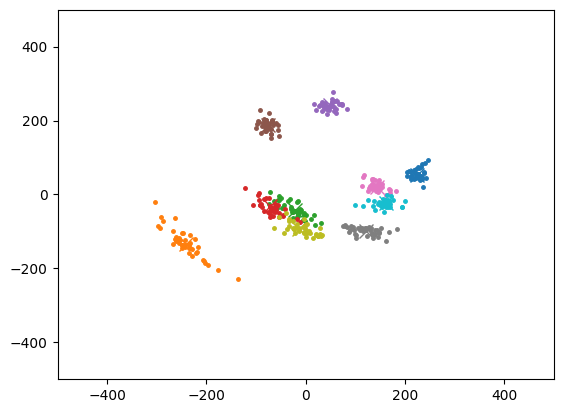

In [5]:
plt.figure()
for i in range(10):
    idx = np.random.randint(0, n_samples)
    plt.plot(*targets[idx, 0, 0].numpy(), f"C{i}x", markersize=10)
    plt.plot(*measurements[idx, 0].T.numpy(), f"C{i}.", markersize=5)
    plt.xlim(-width / 2, width / 2)
    plt.ylim(-width / 2, width / 2)
plt.show()

In [9]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader


n_channels = 8
filter_kernels = 32
n_weights = 16
update_hidden = 32
in_weights = 1
out_weights = 1
max_kernels = 1000
fixed_positions = False
sigma = [10.0, 10.0]
filter_taps = 3
normalize_graph = True
penalty_weight = 1e-4


class UpdatePositions(nn.Module):
    def __init__(self, n_dimensions, n_weights, n_layers, n_hidden) -> None:
        super().__init__()
        dims = n_dimensions + n_weights
        linears = []
        for i in range(n_layers):
            first_layer = i == 0
            last_layer = i == n_layers - 1
            linears.append(
                nn.Linear(
                    dims if first_layer else n_hidden,
                    dims if last_layer else n_hidden,
                )
            )
        self.linears = nn.ModuleList(linears)

    def forward(self, input: Mixture):
        """
        Args:
            input (Mixture): with the following elements.
                positions: (batch_size, n_channels, in_kernels, n_dimensions)
                weights: (batch_size, n_channels, in_kernels, in_weights)
        """
        x = torch.cat([input.positions, input.weights], dim=-1)
        for linear in self.linears:
            x = linear(x)
            x = nn.LeakyReLU()(x)
        positions = x[..., :n_dimensions] + input.positions
        weights = x[..., n_dimensions:] + input.weights
        return Mixture(positions, weights)


class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.n_layers = len(sigma)
        self.nonlinearity = KernelMap(nn.LeakyReLU())
        self.readin = KernelMap(nn.Linear(in_weights, n_weights))
        self.readout = KernelMap(nn.Linear(n_weights, out_weights))
        self.pool = KernelPool(
            out_kernels=max_kernels,
            kernel=GaussianKernel(),
            strategy="largest",
            fit=False,
        )

        conv_layers = []
        norm_layers = []
        graph_layers = []
        update_layers = []
        for l in range(self.n_layers):
            first_layer = l == 0
            last_layer = l == self.n_layers - 1
            norm_layers += [KernelNorm(1 if first_layer else n_channels, n_weights)]
            update_layers += [UpdatePositions(2, n_weights, 2, update_hidden)]
            conv_layers += [
                KernelConv(
                    filter_kernels=filter_kernels,
                    in_channels=1 if first_layer else n_channels,
                    out_channels=1 if last_layer else n_channels,
                    n_dimensions=2,
                    kernel_spread=3 * sigma[l] * filter_kernels**0.5,
                    fixed_positions=fixed_positions,
                    n_weights=n_weights,
                )
            ]
            graph_layers += [
                KernelGraphFilter(
                    kernel=GaussianKernel(sigma[l]),
                    in_weights=n_weights,
                    out_weights=n_weights,
                    filter_taps=filter_taps,
                    normalize=normalize_graph,
                )
            ]
        self.norm_layers = nn.ModuleList(norm_layers)
        self.update_layers = nn.ModuleList(update_layers)
        self.conv_layers = nn.ModuleList(conv_layers)
        self.graph_layers = nn.ModuleList(graph_layers)

    def forward(self, input: Mixture):
        lost_energy = torch.zeros(self.n_layers, device=input.weights.device)

        x = self.readin(input)
        # x = self.nonlinearity(x)
        for l in range(self.n_layers):
            x = self.norm_layers[l](x)
            # x = self.update_layers[l](x)
            x = self.conv_layers[l](x)
            x = self.graph_layers[l](x)
            x = self.nonlinearity(x)
            if l < self.n_layers - 1:
                in_energy = x.weights.pow(2).mean(0).sum()
                x = self.pool(x)
                out_energy = x.weights.pow(2).mean(0).sum()
                lost_energy[l] = 1 - out_energy / in_energy
        x: Mixture = self.readout(x)
        x = self.nonlinearity(x)
        return x, lost_energy.mean()


dataset = TensorDataset(measurements.cuda(), targets.cuda())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = Model().cuda()


# positions should not be regularized
parameters = list(model.named_parameters())
positions = [p for n, p in parameters if "_positions" in n]
weights = [p for n, p in parameters if "_positions" not in n]
optimizer = AdamW(
    [dict(params=weights), dict(params=positions, lr=1e-2, weight_decay=0.0)],
    lr=1e-2,
    weight_decay=0,
)
scheduler = ReduceLROnPlateau(
    optimizer,
    "min",
    factor=0.1,
    patience=2,
    cooldown=2,
)


mse_values = []
for i in range(20):
    pbar = tqdm(dataloader, total=len(dataloader))
    total_loss = 0
    for x, y in pbar:
        x_weights = torch.ones(*x.shape[:-1], device="cuda")[..., None]
        y_weights = torch.ones(*y.shape[:-1], device="cuda")[..., None]
        (z, z_weights), lost_energy = model.forward(Mixture(x, x_weights))

        kernel = GaussianKernel(sigma[-1])
        mse = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()
        mse_values.append(mse.item())
        loss = mse + penalty_weight * lost_energy
        total_loss += loss.item()

        pbar.set_postfix(
            loss=loss.item(),
            mse=mse.item(),
            lost_energy=lost_energy.item(),
            lr=optimizer.param_groups[0]["lr"],
        )

        loss.backward()
        optimizer.step()
    scheduler.step(total_loss)

  0%|          | 0/313 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 7.78 GiB total capacity; 5.07 GiB already allocated; 107.75 MiB free; 5.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

2.55804705619812


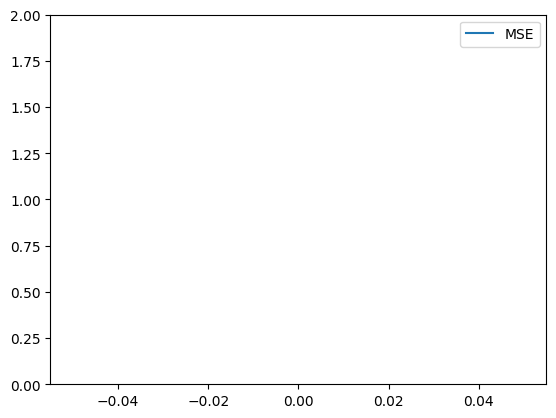

In [ ]:
print(np.mean(mse_values[-10:]))

plt.figure()
plt.plot(mse_values, label="MSE")
plt.legend()
plt.ylim(0, 2)
plt.show()

In [ ]:
def raster_rkhs(X: Mixture, sigma: float, width: float, resolution: int, relu=False):
    XY = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-width / 2, width / 2, resolution),
                torch.linspace(-width / 2, width / 2, resolution),
            ),
            dim=-1,
        )
        .reshape(-1, 2)
        .to(X.positions.device)
    )
    kernel = GaussianKernel(sigma)
    values = kernel(XY, X.positions[0, 0]) @ X.weights
    XY = XY.reshape(resolution, resolution, 2).detach()
    values = values.reshape(resolution, resolution).detach()
    return values, XY

In [ ]:
n_test = 100
indices = np.random.choice(n_samples, n_test, replace=False)

model.eval()
mae_mean = 0
mae_mode = 0
with torch.no_grad():
    for idx in tqdm(indices):
        x = measurements[None, idx, ...].cuda()
        y = targets[None, idx, None, :].cuda()
        x_weights = torch.ones(*x.shape[:-1], device=x.device)[..., None]
        y_weights = torch.ones(*y.shape[:-1], device=y.device)[..., None]

        Z, _ = model(Mixture(x, x_weights))

        # output argmax
        values, XY = raster_rkhs(Z, sigma[-1], width, 1000)
        # values.relu_()
        # expectation
        mean_xy = (XY * values[..., None]).sum((0, 1)) / values.sum()
        mae_mean += ((mean_xy - y.squeeze()).abs()).sum() / n_test
        # mode
        mode_xy = XY.reshape(-1, 2)[torch.argmax(values)]
        mae_mode += ((mode_xy - y.squeeze()).abs()).sum() / n_test
print(f"Mean Absolute Error (MEAN): {mae_mean.item():.2f}")
print(f"Mean Absolute Error (MODE): {mae_mode.item():.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean Absolute Error (MEAN): 25.33
Mean Absolute Error (MODE): 1002.95


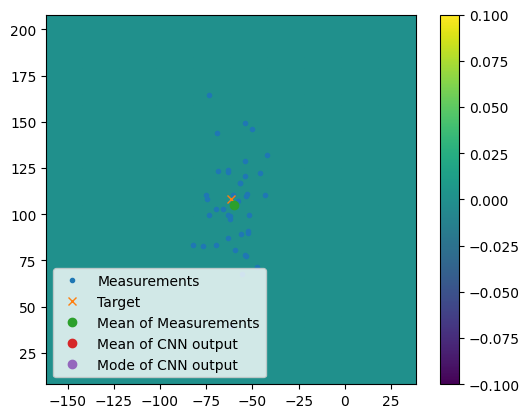

In [ ]:
idx = np.random.randint(0, n_samples)
resolution = 1000


with torch.no_grad():
    x = measurements[None, idx, ...].cuda()
    y = targets[None, idx, None, :].cuda()
    x_weights = torch.ones(*x.shape[:-1], device=x.device)[..., None]
    y_weights = torch.ones(*y.shape[:-1], device=y.device)[..., None]

    model.eval()
    with torch.no_grad():
        z, z_weights = model(Mixture(x, x_weights))[0]
    model.train()

    # squeeze all the tensors
    x = x.squeeze().cpu()
    y = y.squeeze().cpu()

    extent = [-width / 2, width / 2, -width / 2, width / 2]
    values, XY = raster_rkhs(Mixture(z, z_weights), sigma[-1], width, 1000)
    values.relu_()
    # naive way to make predictions
    input_mean = x.mean(0)
    # expectation
    mean_xy = (XY * values[..., None]).sum((0, 1)) / values.sum()
    # mode
    mode_xy = XY.reshape(-1, 2)[torch.argmax(values)]

plt.figure()
plt.imshow(values.T.cpu().detach(), extent=extent, origin="lower")

plt.plot(*x.T, ".", label="Measurements")
plt.plot(*y, "x", label="Target")
plt.plot(*input_mean, "o", label="Mean of Measurements")
plt.plot(*mean_xy.detach().cpu(), "o", label="Mean of CNN output")
plt.plot(*mode_xy.detach().cpu(), "o", label="Mode of CNN output")

# plt.xlim(extent[0], extent[1])
# plt.ylim(extent[2], extent[3])
# axis limits y +- 100
plt.xlim(y[0] - 100, y[0] + 100)
plt.ylim(y[1] - 100, y[1] + 100)

plt.legend()
plt.colorbar()
plt.show()

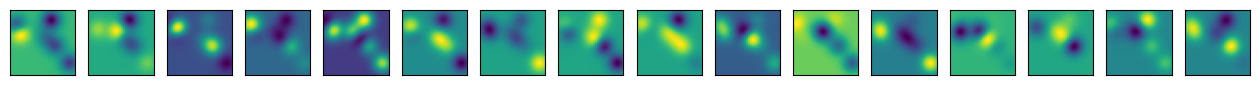

In [ ]:
def raster_filter(
    X: Mixture,
    sigma: float,
    weight_idx: int,
    channel: tuple[int, int],
    width: float,
    resolution: int,
):
    X_ = Mixture(
        X.positions[channel[0], channel[1], None, None, ...],
        X.weights[channel[0], channel[1], None, None, :, weight_idx, None].contiguous(),
    )
    return raster_rkhs(X_, sigma, width, resolution)[0].detach().cpu()


# Plot the CNN Filter at the lth layer
l = 0
channel = (0, 0)


conv_layers = model.conv_layers
positions = conv_layers[l].kernel_positions
weights = conv_layers[l].kernel_weights
assert isinstance(positions, torch.Tensor) and isinstance(weights, torch.Tensor)

n_weights = weights.shape[3]
fig, axs = plt.subplots(
    1,
    n_weights,
    figsize=(n_weights, 1),
    sharex=True,
    sharey=True,
)
for i in range(n_weights):
    rkhs = Mixture(positions, weights)
    filter_width = sigma[l] * 10
    extent = np.array([-1, 1, -1, 1]) * filter_width / 2

    if n_weights > 1:
        ax = axs[i]
    else:
        ax = axs

    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(
        raster_filter(rkhs, sigma[l], i, channel, width=filter_width, resolution=32),
        extent=extent,
        origin="lower",
    )
plt.show()